In [ ]:
!pip install haystack-ai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.1/372.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.9 MB/s eta 0:00:00


In [ ]:
from haystack import Pipeline, Document
from haystack.components.routers import ConditionalRouter
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.components.websearch.serper_dev import SerperDevWebSearch
from haystack.document_stores.in_memory import InMemoryDocumentStore

/usr/local/lib/python3.10/dist-packages/haystack/core/errors.py:34: DeprecationWarning: PipelineMaxLoops is deprecated and will be remove in version '2.7.0'; use PipelineMaxComponentRuns instead.
  warnings.warn(


In [ ]:
import os
from getpass import getpass
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

Enter OpenAI API key:··········


In [ ]:
documents = [Document(content="Retrievers: Retrieves relevant documents to a user query using keyword search or semantic search."),
             Document(content="Embedders: Creates embeddings for text or documents."),
             Document(content="Generators: Use a number of model providers to generate answers or content based on a prompt"),
             Document(content="File Converters: Converts different file types like TXT, Markdown, PDF, etc. into a Haystack Document type")]

document_store = InMemoryDocumentStore()
document_store.write_documents(documents=documents)

4

In [ ]:
rag_prompt_template = """
Answer the following query given the documents.
If the answer is not contained within the documents, reply with 'no_answer'
Query: {{query}}
Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}
"""

# Conditional Router

Now that you got the model to respond with an answer or `no_answer`, you can create pipeline branches that are activated according to this response using the [`ConditionalRouter`](https://docs.haystack.deepset.ai/docs/conditionalrouter?utm_campaign=developer-relations&utm_source=dlai) component for this.

In [ ]:
routes = [
    {
        "condition": "{{'no_answer' in replies[0]|lower}}",
        "output": "{{query}}",
        "output_name": "go_to_websearch",
        "output_type": str,
    },
    {
        "condition": "{{'no_answer' not in replies[0]|lower}}",
        "output": "{{replies[0]}}",
        "output_name": "answer",
        "output_type": str,
    },
]

## Websearch

In [ ]:
prompt_for_websearch = """
Answer the following query given the documents retrieved from the web.
Your answer should indicate that your answer was generated from websearch.
You can also reference the URLs that the answer was generated from

Query: {{query}}
Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}
"""

In [ ]:
os.environ["SERPERDEV_API_KEY"] = getpass("Enter Serpdev API key:")

Enter Serpdev API key:··········


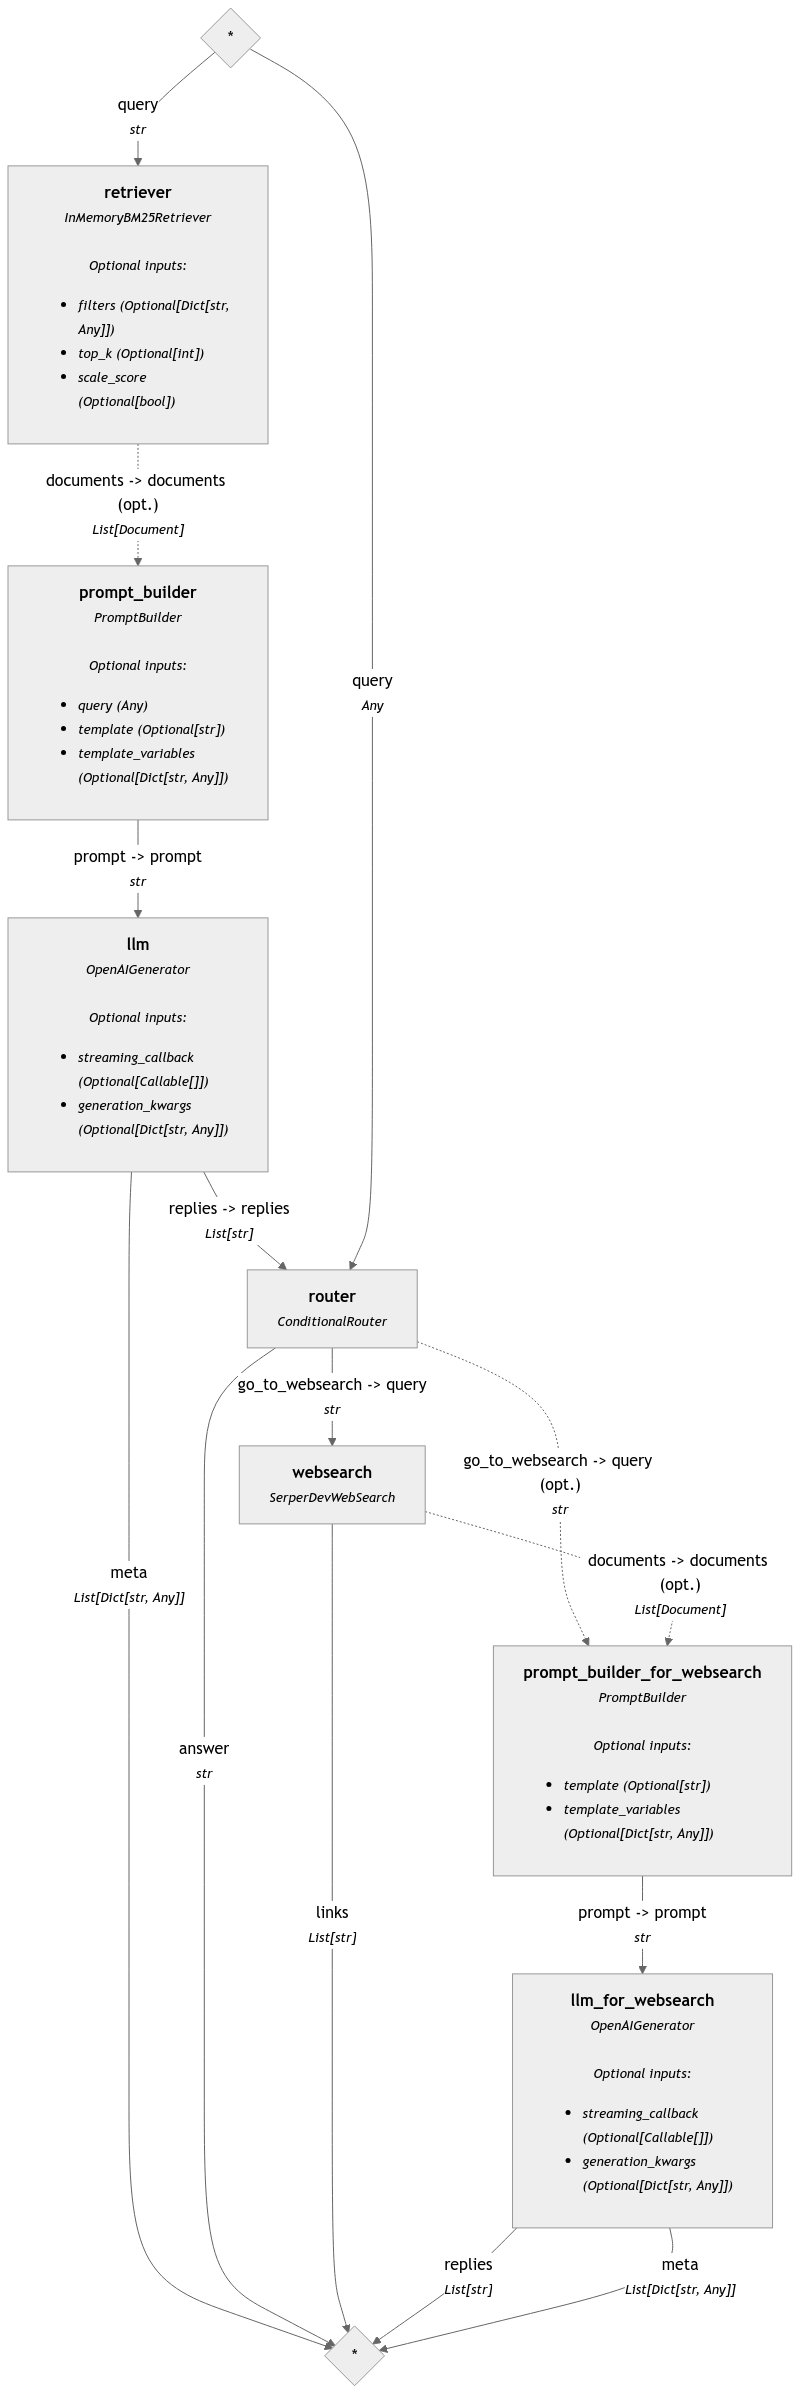

In [ ]:
rag_or_websearch = Pipeline()
rag_or_websearch.add_component("retriever", InMemoryBM25Retriever(document_store=document_store))
rag_or_websearch.add_component("prompt_builder", PromptBuilder(template=rag_prompt_template))
rag_or_websearch.add_component("llm", OpenAIGenerator())
rag_or_websearch.add_component("router", ConditionalRouter(routes))
rag_or_websearch.add_component("websearch", SerperDevWebSearch())
rag_or_websearch.add_component("prompt_builder_for_websearch", PromptBuilder(template=prompt_for_websearch))
rag_or_websearch.add_component("llm_for_websearch",  OpenAIGenerator())

rag_or_websearch.connect("retriever", "prompt_builder.documents")
rag_or_websearch.connect("prompt_builder", "llm")
rag_or_websearch.connect("llm.replies", "router.replies")
rag_or_websearch.connect("router.go_to_websearch", "websearch.query")
rag_or_websearch.connect("router.go_to_websearch", "prompt_builder_for_websearch.query")
rag_or_websearch.connect("websearch.documents", "prompt_builder_for_websearch.documents")
rag_or_websearch.connect("prompt_builder_for_websearch", "llm_for_websearch")

rag_or_websearch.show()

In [ ]:
#rag_or_websearch.show()

In [ ]:
query= "What is a retriever for?"

rag_or_websearch.run({"prompt_builder":{"query": query},
                      "retriever": {"query": query},
                      "router": {"query": query}})

{'llm': {'meta': [{'model': 'gpt-3.5-turbo-0125',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 20,
     'prompt_tokens': 117,
     'total_tokens': 137}}]},
 'router': {'answer': 'Retrievers are used to retrieve relevant documents to a user query using keyword search or semantic search.'}}

In [ ]:
query = "Why was the SpaceX Crew-8 astronaut hospitalized with ‘medical issue’ "

rag_or_websearch.run({"prompt_builder":{"query": query},
                      "retriever": {"query": query},
                      "router": {"query": query}})

{'llm': {'meta': [{'model': 'gpt-4o-mini-2024-07-18',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 2,
     'prompt_tokens': 52,
     'total_tokens': 54,
     'completion_tokens_details': CompletionTokensDetails(audio_tokens=None, reasoning_tokens=0),
     'prompt_tokens_details': PromptTokensDetails(audio_tokens=None, cached_tokens=0)}}]},
 'websearch': {'links': ['https://www.cnn.com/2024/10/25/science/spacex-nasa-crew-8-medical-facility/index.html',
   'https://abcnews.go.com/US/spacex-crew-8-astronaut-remains-hospital-after-returning/story?id=115178985',
   'https://spacenews.com/crew-8-astronaut-released-from-hospital/',
   'https://www.nytimes.com/2024/10/25/science/nasa-spacex-astronaut-hospital.html',
   'https://scitechdaily.com/nasa-astronaut-hospitalized-unraveling-the-medical-mystery-after-crew-8s-space-odyssey/',
   'https://www.reddit.com/r/space/comments/1gc25nd/spacex_crew8_astronaut_hospitalized_in_pensacola/',
   'https://blogs.nasa.g

# Hacker News Agent

In [ ]:
!pip install trafilatura

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.2/132.2 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 837.8/837.8 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: lxml
    Found existing installation: lxml 4.9.4
    Uninstalling lxml-4.9.4:
      Successfully uninstalled lxml-4.9.4


In [ ]:
from typing import List
from trafilatura import fetch_url, extract
import requests
from getpass import getpass
import os

from haystack_experimental.components.generators.chat import OpenAIChatGenerator
from haystack_experimental.dataclasses import Tool, ChatMessage
from haystack_experimental.components.tools import ToolInvoker

from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator

In [ ]:
def hacker_news_fetcher(top_k: int = 3):
    newest_list = requests.get(url='https://hacker-news.firebaseio.com/v0/topstories.json?print=pretty')
    urls = []
    articles = []
    for id_ in newest_list.json()[0:top_k]:
        article = requests.get(url=f"https://hacker-news.firebaseio.com/v0/item/{id_}.json?print=pretty")
        if 'url' in article.json():
            urls.append(article.json()['url'])
        elif 'text' in article.json():
            articles.append(article.json()['text'])

    for url in urls:
        try:
            downloaded = fetch_url(url)
            text = extract(downloaded)
            if text is not None:
                articles.append(text[:500])
        except Exception as e:
            print(e)
            print(f"Couldn't download {url}, skipped")

    return articles


In [ ]:
hacker_news_fetcher_tool = Tool(name="hacker_news_fetcher",
                                description="Fetch the top k articles from hacker news",
                                function=hacker_news_fetcher,
                                parameters={
                                    "type": "object",
                                    "properties": {
                                        "top_k": {
                                            "type": "integer",
                                            "description": "The number of articles to fetch"
                                        }
                                    },
                                })


In [ ]:
template = """
Create a entertaining newsletter for {{target_people}} based on the following articles.
The newsletter should be well structured, with a unique angle and a maximum of {{n_words}} words.

Articles:
{% for article in articles %}
    {{ article }}
    ---
{% endfor %}
"""

newsletter_pipe = Pipeline()
newsletter_pipe.add_component("prompt_builder", PromptBuilder(template=template))
newsletter_pipe.add_component("llm", OpenAIGenerator(model="gpt-4o-mini"))
newsletter_pipe.connect("prompt_builder", "llm")


🚅 Components
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - prompt_builder.prompt -> llm.prompt (str)

In [ ]:
def newsletter_pipeline_func(articles: List[str], target_people: str = "programmers", n_words: int = 100):
    result = newsletter_pipe.run({"prompt_builder": {"articles": articles, "target_people": target_people, "n_words": n_words}})

    return {"reply": result["llm"]["replies"][0]}

newsletter_tool = Tool(name="newsletter_generator",
                          description="Generate a newsletter based on some articles",
                            function=newsletter_pipeline_func,
                            parameters={
                                "type": "object",
                                "properties": {
                                    "articles": {
                                        "type": "array",
                                        "items": {
                                            "type": "string",
                                            "description": "The articles to base the newsletter on",
                                        }
                                    },
                                    "target_people": {
                                        "type": "string",
                                        "description": "The target audience for the newsletter",
                                    },
                                    "n_words": {
                                        "type": "integer",
                                        "description": "The number of words to summarize the newsletter to",
                                    }
                                },
                                "required": ["articles"],
                            })


In [ ]:
chat_generator = OpenAIChatGenerator(tools=[hacker_news_fetcher_tool, newsletter_tool])

tool_invoker = ToolInvoker(tools=[hacker_news_fetcher_tool, newsletter_tool])

messages = [
        ChatMessage.from_system(
            """Prepare a tool call if needed, otherwise use your knowledge to respond to the user.
            If the invocation of a tool requires the result of another tool, prepare only one call at a time.

            Each time you receive the result of a tool call, ask yourself: "Am I done with the task?".
            If not and you need to invoke another tool, prepare the next tool call.
            If you are done, respond with just the final result."""
        )
    ]

while True:
    user_input = input("\n\nwaiting for input (type 'exit' or 'quit' to stop)\n🧑: ")
    if user_input.lower() == "exit" or user_input.lower() == "quit":
        break
    messages.append(ChatMessage.from_user(user_input))

    while True:
        print("⌛ iterating...")

        replies = chat_generator.run(messages=messages)["replies"]
        messages.extend(replies)

        # Check for tool calls and handle them
        if not replies[0].tool_calls:
            break
        tool_calls = replies[0].tool_calls

        # Print tool calls for debugging
        for tc in tool_calls:
            print("\n TOOL CALL:")
            print(f"\t{tc.id}")
            print(f"\t{tc.tool_name}")
            for k,v in tc.arguments.items():
                v_truncated = str(v)[:50]
                print(f"\t{k}: {v_truncated}{'' if len(v_truncated) == len(str(v)) else '...'}")

        tool_messages = tool_invoker.run(messages=replies)["tool_messages"]
        messages.extend(tool_messages)


    # Print the final AI response after all tool calls are resolved
    print(f"🤖: {messages[-1].text}")




waiting for input (type 'exit' or 'quit' to stop)
🧑: Write a newsletter article about the top 2 hacker rank articles
⌛ iterating...

 TOOL CALL:
	call_AuBcjGyqJo04yLb2Upqxrqgv
	hacker_news_fetcher
	top_k: 2
⌛ iterating...

 TOOL CALL:
	call_M22qLWkjgdcSsLNZb5BjyiJS
	newsletter_generator
	articles: ["Understanding Round Robin DNS\nIn which I try to...
	target_people: tech enthusiasts
	n_words: 300
⌛ iterating...
🤖: **Tech Tidbits: Your Monthly Byte of Innovation**  
*Issue #42 | October 2023*

**Hello, Tech Titans!**

Welcome back to your favorite source of tech insights, where every article is a nugget of wisdom waiting to be mined! This month, we're slicing through complex concepts like a hot knife through butter, and we’re here to serve it all with a side of fun.

---

**🍕 Round Robin DNS: The Pizza Delivery of the Internet**  
Ever wondered how your browser decides which server to grab your website from? Think of it like ordering pizza; you love variety! Round Robin DNS is the piz

# Self-Reflecting Agent

In [ ]:
!pip install colorama

In [ ]:
from typing import List
from colorama import Fore
from haystack import Pipeline, component
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack.components.generators.openai import OpenAIGenerator

/usr/local/lib/python3.10/dist-packages/haystack/core/errors.py:34: DeprecationWarning: PipelineMaxLoops is deprecated and will be remove in version '2.7.0'; use PipelineMaxComponentRuns instead.
  warnings.warn(


In [ ]:
@component
class EntitiesValidator:

    @component.output_types(entities_to_validate=str, entities=str)
    def run(self, replies: List[str]):
        if 'DONE' in replies[0]:
            return {"entities":replies[0].replace('DONE', '')}
        else:
            print(Fore.RED + "Reflecting on entities\n", replies[0])
            return {"entities_to_validate": replies[0]}

In [ ]:
template = """"
{% if entities_to_validate %}
    Here was the text you were provided:
    {{ text }}
    Here are the entities you previously extracted:
    {{ entities_to_validate[0] }}
    Are these the correct entities?
    Things to check for:
    - Entity categories should exactly be "Person", "Location" and "Date"
    - There should be no extra categories
    - There should be no duplicate entities
    - If there are no appropriate entities for a category, the category should have an empty list
    If you are done say 'DONE' and return your new entities in the next line
    If not, simply return the best entities you can come up with.
    Entities:
{% else %}
    Extract entities from the following text
    Text: {{ text }}
    The entities should be presented as key-value pairs in a JSON object.
    Example:
    {
        "Person": ["value1", "value2"],
        "Location": ["value3", "value4"],
        "Date": ["value5", "value6"]
    }
    If there are no possibilities for a particular category, return an empty list for this
    category
    Entities:
{% endif %}
"""

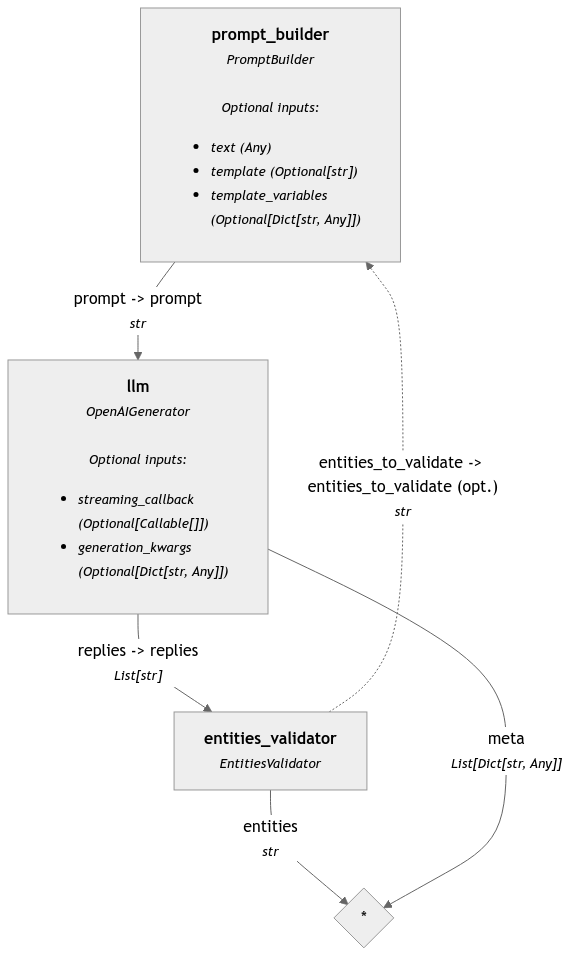

In [ ]:
prompt_template = PromptBuilder(template=template)
llm = OpenAIGenerator()
entities_validator = EntitiesValidator()

self_reflecting_agent = Pipeline(max_loops_allowed=10)

self_reflecting_agent.add_component("prompt_builder", prompt_template)
self_reflecting_agent.add_component("entities_validator", entities_validator)
self_reflecting_agent.add_component("llm", llm)

self_reflecting_agent.connect("prompt_builder.prompt", "llm.prompt")
self_reflecting_agent.connect("llm.replies", "entities_validator.replies")
self_reflecting_agent.connect("entities_validator.entities_to_validate", "prompt_builder.entities_to_validate")
self_reflecting_agent.show()

In [ ]:
text = """
Istanbul is the largest city in Turkey, straddling the Bosporus Strait,
the boundary between Europe and Asia. It is considered the country's economic,
cultural and historic capital. The city has a population of over 15 million residents,
comprising 19% of the population of Turkey,[4] and is the most populous city in Europe
and the world's fifteenth-largest city."""

result = self_reflecting_agent.run({"prompt_builder": {"text": text}})
print(Fore.GREEN + result['entities_validator']['entities'])

Reflecting on entities
 ```json
{
    "Person": [],
    "Location": ["Istanbul", "Turkey", "Bosporus Strait", "Europe", "Asia"],
    "Date": []
}
```
Entities:
```
Location: ["Istanbul", "Turkey", "Bosporus Strait", "Europe", "Asia"]
Person: []
Date: []
```



# SQL RAG

In [ ]:
from urllib.request import urlretrieve
from zipfile import ZipFile
import pandas as pd


url = "https://archive.ics.uci.edu/static/public/445/absenteeism+at+work.zip"

# download the file
urlretrieve(url, "Absenteeism_at_work_AAA.zip")

print("Extracting the Absenteeism at work dataset...")
# Extract the CSV file
with ZipFile("Absenteeism_at_work_AAA.zip", 'r') as zf:
    zf.extractall()

# Check the extracted CSV file name (in this case, it's "Absenteeism_at_work.csv")
csv_file_name = "Absenteeism_at_work.csv"

print("Cleaning up the Absenteeism at work dataset...")
# Data clean up
df = pd.read_csv(csv_file_name, sep=";")
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.replace('/', '_')
import sqlite3

connection = sqlite3.connect('absenteeism.db')
print("Opened database successfully")

connection.execute('''CREATE TABLE IF NOT EXISTS absenteeism (ID integer,
                        Reason_for_absence integer,
                        Month_of_absence integer,
                        Day_of_the_week integer,
                        Seasons integer,
                        Transportation_expense integer,
                        Distance_from_Residence_to_Work integer,
                        Service_time integer,
                        Age integer,
                        Work_load_Average_day_ integer,
                        Hit_target integer,
                        Disciplinary_failure integer,
                        Education integer,
                        Son integer,
                        Social_drinker integer,
                        Social_smoker integer,
                        Pet integer,
                        Weight integer,
                        Height integer,
                        Body_mass_index integer,
                        Absenteeism_time_in_hours integer);''')
connection.commit()

df.to_sql('absenteeism', connection, if_exists='replace', index = False)
connection.close()



Extracting the Absenteeism at work dataset...
Cleaning up the Absenteeism at work dataset...
Opened database successfully


In [ ]:
from typing import List
from haystack import component

@component
class SQLQuery:

    def __init__(self, sql_database: str):
      self.connection = sqlite3.connect(sql_database, check_same_thread=False)

    @component.output_types(results=List[str], queries=List[str])
    def run(self, queries: List[str]):
        results = []
        for query in queries:
          result = pd.read_sql(query, self.connection)
          results.append(f"{result}")
        return {"results": results, "queries": queries}

sql_query = SQLQuery('absenteeism.db')


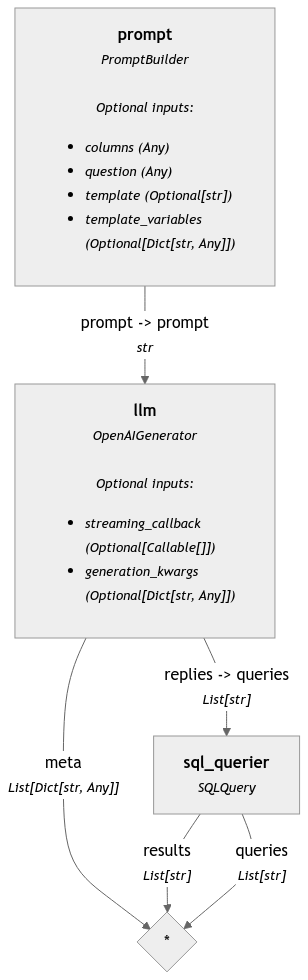

In [ ]:
import os
from getpass import getpass

from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack.components.generators.openai import OpenAIGenerator

prompt = PromptBuilder(template="""Please generate an SQL query. The query should answer the following Question: {{question}};
            The query is to be generated for the table called 'absenteeism' with the following
            Columns: {{columns}};
            Answer:""")
sql_query = SQLQuery('absenteeism.db')
llm = OpenAIGenerator(model="gpt-4")

sql_pipeline = Pipeline()
sql_pipeline.add_component("prompt", prompt)
sql_pipeline.add_component("llm", llm)
sql_pipeline.add_component("sql_querier", sql_query)

sql_pipeline.connect("prompt", "llm")
sql_pipeline.connect("llm.replies", "sql_querier.queries")

sql_pipeline.show()


In [ ]:
result = sql_pipeline.run({"prompt": {"question": "Which day of the week has the most absenteeism?",
                            "columns": df.columns}})

print(result["sql_querier"]["results"][0])


   Day_of_the_week  Total_Absence
0                2            161


In [ ]:
result

{'llm': {'meta': [{'model': 'gpt-4-0613',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 37,
     'prompt_tokens': 170,
     'total_tokens': 207,
     'completion_tokens_details': CompletionTokensDetails(audio_tokens=None, reasoning_tokens=0),
     'prompt_tokens_details': PromptTokensDetails(audio_tokens=None, cached_tokens=0)}}]},
 'sql_querier': {'results': ['   Day_of_the_week  Total_Absence\n0                2            161'],
  'queries': ['SELECT Day_of_the_week, COUNT(*) AS Total_Absence\nFROM absenteeism\nGROUP BY Day_of_the_week\nORDER BY Total_Absence DESC\nLIMIT 1;']}}